In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Image Captioning : Encoder-Decoder model

Load Images and Captions

In [ ]:
#--------------------------------------------------
# load the file containing all of the captions into a single long string
#--------------------------------------------------
caption_file = "/content/drive/MyDrive/ML/Flickr8k_text/Flickr8k.token.txt"
def load_captions (filename):
  with open(filename, "r") as fp:
    # Read all text in the file
    text = fp.read()
    return (text)

#--------------------------------------------------
# Each photo has a unique identifier, which is the file name of the image .jpg file
# Create a dictionary of photo identifiers (without the .jpg) to captions. Each photo identifier maps to
# a list of one or more textual descriptions.
#
# {"image_name_1" : ["caption 1", "caption 2", "caption 3"],
#  "image_name_2" : ["caption 4", "caption 5"]}
#--------------------------------------------------
def captions_dict (text):
  dict = {}

  # Make a List of each line in the file
  lines = text.split ('\n')
  for line in lines:

    # Split into the <image_data> and <caption>
    line_split = line.split ('\t')
    if (len(line_split) != 2):
      # Added this check because dataset contains some blank lines
      continue
    else:
      image_data, caption = line_split

    # Split into <image_file> and <caption_idx>
    image_file, caption_idx = image_data.split ('#')
    # Split the <image_file> into <image_name>.jpg
    image_name = image_file.split ('.')[0]

    # If this is the first caption for this image, create a new list for that
    # image and add the caption to it. Otherwise append the caption to the
    # existing list
    if (int(caption_idx) == 0):
      dict [image_name] = [caption]
    else:
      dict [image_name].append (caption)

  return (dict)

doc = load_captions (caption_file)
image_dict = captions_dict (doc)

In [ ]:
image_dict

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a gi

Then use the Training List text file to select the subset of images to be used for training from our full dataset.

In [ ]:
#--------------------------------------------------
# We have three separate files which contain the names for the subset of
# images to be used for training, validation or testing respectively
#
# Given a file, we return a set of image names (without .jpg extension) in that file
#--------------------------------------------------
def subset_image_name (filename):
  data = []

  with open(filename, "r") as fp:
    # Read all text in the file
    text = fp.read()

    # Make a List of each line in the file
    lines = text.split ('\n')
    for line in lines:
      # skip empty lines
      if (len(line) < 1):
        continue

      # Each line is the <image_file>
      # Split the <image_file> into <image_name>.jpg
      image_name = line.split ('.')[0]

      # Add the <image_name> to the list
      data.append (image_name)

    return (set(data))

training_image_name_file = "/content/drive/MyDrive/ML/Flickr8k_text/Flickr_8k.trainImages.txt"
training_image_names = subset_image_name (training_image_name_file)

In [ ]:
print(training_image_names)

{'197142902_f05ff198c2', '2587846523_b177c9a3e3', '195084264_72fb347b0f', '2943384009_c8cf749181', '3293751136_b0ce285dc3', '3475581086_a533567561', '477768471_d7cd618fdb', '326334188_8850b7bfd4', '2206594874_5e0087c6b7', '3477672764_7f07657a26', '3181599388_68559cfc17', '2318502106_33f2e4b4fc', '1236964638_1808784a3c', '3132903412_b4780d0ccf', '747242766_afdc9cb2ba', '3373069977_bc73e9e409', '2632366677_43dee456a5', '3050650135_23f9d9d2f8', '542405691_0594b1ce72', '1895768965_43cd9d164f', '2561341745_2d77d3ff7d', '2715155329_1ed1756000', '3309578722_1765d7d1af', '426191845_1e979e9345', '2788652511_4f10060e07', '2651915425_7a58e862e9', '3134092148_151154139a', '497579819_f91b26f7d3', '3054989420_3e755ca352', '979201222_75b6456d34', '3325910784_5ecb88310c', '2290589734_b588471345', '2396669903_5217a83641', '1659358133_95cd1027bd', '3251234434_d01e25a50a', '2423138514_950f79e432', '3055716848_b253324afc', '870710405_51e507b31a', '241347441_d3dd9b129f', '2904129133_e6ae5a1ec6', '354752413

Pre-process Images

In [ ]:
import numpy as np
import tensorflow as tf

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

from tqdm import tqdm

image_dir = "/content/drive/MyDrive/ML/Flicker8k_Dataset/"
training_image_paths = [image_dir + name + '.jpg' for name in training_image_names]
print(training_image_paths)
# Get unique images
encode_train = sorted(set(training_image_paths))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

['/content/drive/MyDrive/ML/Flicker8k_Dataset/197142902_f05ff198c2.jpg', '/content/drive/MyDrive/ML/Flicker8k_Dataset/2587846523_b177c9a3e3.jpg', '/content/drive/MyDrive/ML/Flicker8k_Dataset/195084264_72fb347b0f.jpg', '/content/drive/MyDrive/ML/Flicker8k_Dataset/2943384009_c8cf749181.jpg', '/content/drive/MyDrive/ML/Flicker8k_Dataset/3293751136_b0ce285dc3.jpg', '/content/drive/MyDrive/ML/Flicker8k_Dataset/3475581086_a533567561.jpg', '/content/drive/MyDrive/ML/Flicker8k_Dataset/477768471_d7cd618fdb.jpg', '/content/drive/MyDrive/ML/Flicker8k_Dataset/326334188_8850b7bfd4.jpg', '/content/drive/MyDrive/ML/Flicker8k_Dataset/2206594874_5e0087c6b7.jpg', '/content/drive/MyDrive/ML/Flicker8k_Dataset/3477672764_7f07657a26.jpg', '/content/drive/MyDrive/ML/Flicker8k_Dataset/3181599388_68559cfc17.jpg', '/content/drive/MyDrive/ML/Flicker8k_Dataset/2318502106_33f2e4b4fc.jpg', '/content/drive/MyDrive/ML/Flicker8k_Dataset/1236964638_1808784a3c.jpg', '/content/drive/MyDrive/ML/Flicker8k_Dataset/313290341

100%|██████████| 375/375 [05:21<00:00,  1.16it/s]


Prepare captions

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import re

#--------------------------------------------------
# Clean the captions data
#    Convert all words to lowercase.
#    Remove all punctuation.
#    Remove all words that are one character or less in length (e.g. ‘a’).
#    Remove all words with numbers in them.
#--------------------------------------------------
def captions_clean (image_dict):
  # <key> is the image_name, which can be ignored
  for key, captions in image_dict.items():

    # Loop through each caption for this image
    for i, caption in enumerate (captions):

      # Convert the caption to lowercase, and then remove all special characters from it
      caption_nopunct = re.sub(r"[^a-zA-Z0-9]+", ' ', caption.lower())

      # Split the caption into separate words, and collect all words which are more than
      # one character and which contain only alphabets (ie. discard words with mixed alpha-numerics)
      clean_words = [word for word in caption_nopunct.split() if ((len(word) > 1) and (word.isalpha()))]

      # Join those words into a string
      caption_new = ' '.join(clean_words)

      # Replace the old caption in the captions list with this new cleaned caption
      captions[i] = caption_new

#--------------------------------------------------
# Add two tokens, 'startseq' and 'endseq' at the beginning and end respectively,
# of every caption
#--------------------------------------------------
def add_token (captions):
  for i, caption in enumerate (captions):
    captions[i] = 'startseq ' + caption + ' endseq'
  return (captions)

#--------------------------------------------------
# Given a set of training, validation or testing image names, return a dictionary
# containing the corresponding subset from the full dictionary of images with captions
#
# This returned subset has the same structure as the full dictionary
# {"image_name_1" : ["caption 1", "caption 2", "caption 3"],
#  "image_name_2" : ["caption 4", "caption 5"]}
#--------------------------------------------------
def subset_data_dict (image_dict, image_names):
  dict = { image_name:add_token(captions) for image_name,captions in image_dict.items() if image_name in image_names}
  return (dict)

#--------------------------------------------------
# Flat list of all captions
#--------------------------------------------------
def all_captions (data_dict):
  return ([caption for key, captions in data_dict.items() for caption in captions])

#--------------------------------------------------
# Calculate the word-length of the caption with the most words
#--------------------------------------------------
def max_caption_length(captions):
  return max(len(caption.split()) for caption in captions)

#--------------------------------------------------
# Fit a Keras tokenizer given caption descriptions
# The tokenizer uses the captions to learn a mapping from words to numeric word indices
#
# Later, this tokenizer will be used to encode the captions as numbers
#--------------------------------------------------
def create_tokenizer(data_dict):
  captions = all_captions(data_dict)
  max_caption_words = max_caption_length(captions)

  # Initialise a Keras Tokenizer
  tokenizer = Tokenizer()

  # Fit it on the captions so that it prepares a vocabulary of all words
  tokenizer.fit_on_texts(captions)

  # Get the size of the vocabulary
  vocab_size = len(tokenizer.word_index) + 1

  return (tokenizer, vocab_size, max_caption_words)

#--------------------------------------------------
# Extend a list of text indices to a given fixed length
#--------------------------------------------------
def pad_text (text, max_length):
  text = pad_sequences([text], maxlen=max_length, padding='post')[0]

  return (text)

captions_clean (image_dict)
training_dict = subset_data_dict (image_dict, training_image_names)

# Prepare tokenizer
tokenizer, vocab_size, max_caption_words = create_tokenizer(training_dict)

**Prepare Training Data using a Tensorflow Dataset**
We now have pre-processed images and captions. We go through every training image and its matching captions to prepare the training data. This consists of:
Features (X) consisting of the image file paths
Targets (y) consisting of the cleaned and tokenized captions

In [ ]:
from array import array
def data_prep(data_dict, tokenizer, max_length, vocab_size):
  X, y = list(), list()

  # For each image and list of captions
  for image_name, captions in data_dict.items():
    image_name = image_dir + image_name + '.jpg'

    # For each caption in the list of captions
    for caption in captions:

      # Convert the caption words into a list of word indices
      word_idxs = tokenizer.texts_to_sequences([caption])[0]

      # Pad the input text to the same fixed length
      pad_idxs = pad_text(word_idxs, max_length)

      X.append(image_name)
      y.append(pad_idxs)

  #return array(X), array(y)
  return X, y

train_X, train_y = data_prep(training_dict, tokenizer, max_caption_words, vocab_size)

We wrap the training data in a Tensorflow Dataset object so that it can be efficiently fetched and fed, one batch at a time, to the model during training. The data is fetched lazily so that it doesn’t all have to be in memory at the same time. This allows us to support very large datasets.
The dataset loads the pre-processed encoded image vectors that were saved earlier. It uses the image file name to identify the saved file path.

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# Load the numpy files
def map_func(img_name, cap):
   img_tensor = np.load(img_name.decode('utf-8')+'.npy')
   return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

**Image Caption Model with Attention**
The model consists of four logical components:
Encoder: since the image encoding has already been done by the pre-trained Inception model, the Encoder here is very simple. It consists of a Linear layer that takes the pre-encoded image features and passes them on to the Decoder.
Sequence Decoder: this is a recurrent network built with GRUs. The captions are passed in as the input after first going through an Embedding layer.
Attention: as the Decoder generates each word of the output sequence, the Attention module helps it to focus on the most relevant part of the image for generating that word.
Sentence Generator: this module consists of a couple of Linear layers. It takes the output from the Decoder and produces a probability for each word from the vocabulary, for each position in the predicted seque

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

**Training**

In [ ]:
embedding_dim = 256
units = 512
vocab_size = vocab_size
num_steps = len(train_X) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

loss_plot = []
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['startseq']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

import time
start_epoch = 0
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.7974
Epoch 1 Batch 100 Loss 1.4997
Epoch 1 Batch 200 Loss 1.3575
Epoch 1 Batch 300 Loss 1.2447
Epoch 1 Batch 400 Loss 1.2348
Epoch 1 Loss 1.390071
Time taken for 1 epoch 249.75 sec

Epoch 2 Batch 0 Loss 1.1802
Epoch 2 Batch 100 Loss 1.0871
Epoch 2 Batch 200 Loss 1.1267
Epoch 2 Batch 300 Loss 0.9480
Epoch 2 Batch 400 Loss 1.0154
Epoch 2 Loss 1.085716
Time taken for 1 epoch 163.98 sec

Epoch 3 Batch 0 Loss 0.9493
Epoch 3 Batch 100 Loss 0.9842
Epoch 3 Batch 200 Loss 1.0709
Epoch 3 Batch 300 Loss 0.8295
Epoch 3 Batch 400 Loss 0.9106
Epoch 3 Loss 0.973869
Time taken for 1 epoch 163.62 sec

Epoch 4 Batch 0 Loss 0.9220
Epoch 4 Batch 100 Loss 0.8903
Epoch 4 Batch 200 Loss 0.9053
Epoch 4 Batch 300 Loss 0.9244
Epoch 4 Batch 400 Loss 0.9824
Epoch 4 Loss 0.895929
Time taken for 1 epoch 163.26 sec

Epoch 5 Batch 0 Loss 0.9152
Epoch 5 Batch 100 Loss 0.7542
Epoch 5 Batch 200 Loss 0.9166
Epoch 5 Batch 300 Loss 0.8397
Epoch 5 Batch 400 Loss 0.7706
Epoch 5 Loss 0.833600
Time taken

**Testing**
We extract image features from the test image using the pre-trained model. The next steps to generate a caption are very similar to what we did during training, with the following changes:
Greedy Search is used to predict the output by picking the word with the highest probability at each timestep.
 At each timestep, the predicted word is appended to the input sequence and fed back to the Decoder for the next timestep.

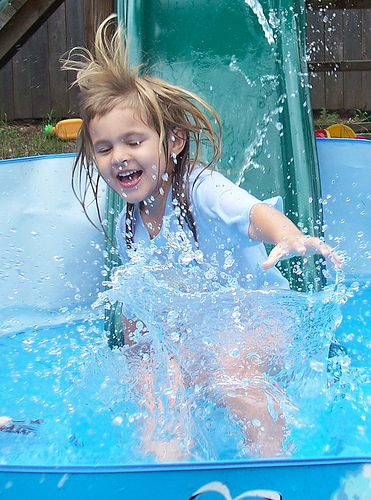

Real Caption: ['child slides down slide and into the water', 'girl sliding into pool', 'little girl in white shirt sliding down green slide splashing into blue baby pool', 'little girl splashes in pool of water', 'little girl slides down in the pool']
Prediction Caption: blond girl in blue pool with blue pool is in red kayak going down water endseq


In [ ]:
def evaluate(image, max_length):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['startseq']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == 'endseq':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

def check_test(test_image_names, image_dict, image_dir, max_caption_words):
  # captions on the validation set
  rid = np.random.randint(0, len(test_image_names))
  image_name = test_image_names[rid]
  real_caption = image_dict[image_name]

  image_path = image_dir + image_name + '.jpg'
  result, attention_plot = evaluate(image_path, max_caption_words)

  from IPython.display import Image, display
  display(Image(image_path))
  print('Real Caption:', real_caption)
  print('Prediction Caption:', ' '.join(result))

test_image_name_file = "/content/drive/MyDrive/ML/Flickr8k_text/Flickr_8k.testImages.txt"
test_image_names = subset_image_name (test_image_name_file)
image_dir = "/content/drive/MyDrive/ML/Flicker8k_Dataset/"
check_test(list(test_image_names), image_dict, image_dir, max_caption_words)